In [1]:
%cd ~/XENON\ emission\ model\ PPL/marginalised\ numpyro\ model

import os
PATH = os.getenv('PATH')
%env PATH=/home/juehang/.conda/envs/numpyro_gpu/bin:$PATH
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = '0.3'
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import arviz as az

from functools import partial

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np

import scipy.stats as spystats

from tqdm import trange, tqdm

import jax
from jax import config, jit, lax, random
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.scipy import stats
from jax.scipy.special import gammaln, xlogy, xlog1py


from bayesNEST import NEST
import bayesNEST.distributions as bdist
import bayesNEST.pmf_marginalization as pmfm

# import numpyro
# from numpyro.infer import MCMC, NUTS

import blackjax
from blackjax.progress_bar import progress_bar_scan

/home/juehang/XENON emission model PPL/marginalised numpyro model
env: PATH=/home/juehang/.conda/envs/numpyro_gpu/bin:/opt/conda/envs/jupyterhub/bin:/opt/conda/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


2023-12-09 17:24:55.549475: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.2 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
device_cpu = jax.devices('cpu')[0]
device_gpu = jax.devices('gpu')[1]
jax.config.update("jax_platform_name", 'gpu')
jax.config.update("jax_default_device", device_gpu)
# numpyro.set_platform('cpu')
# numpyro.set_host_device_count(1)

In [3]:
import nestpy
detector = nestpy.VDetector()

A = 131.293 # avg atomic mass of Xe
Z = 54. # Atomic number of Xe 

detector.set_T_Kelvin(177)
nc = nestpy.NESTcalc(detector)

# density = nc.GetDensity( T=detector.get_T_Kelvin(), P=detector.get_p_bar(), inGas=False )
density = nc.GetDensity( T=detector.get_T_Kelvin(), P=detector.get_p_bar(), inGas=False )
# nc.SetDensity(detector.get_T_Kelvin(), detector.get_p_bar())
# density = nc.GetDensity()
print( "Using detector's LXe density, %.3f g/cc" % density)

@np.vectorize
def GetQuanta(interaction=nestpy.beta, 
              energy=100., # energy in keV of the recoil itself
              drift_field=60.): # V/cm
    
    #What's first done in nestpy is getting the yields 
    #Based on the arguments below; most important, energy, density, field.
    #To see the spectrum of these, see nest.ucdavis.edu/benchmarkplots 
    y = nc.GetYields(interaction,
     energy,
     density,
     drift_field,
     A,
     Z,
    ) 
    # Then we call nestcalc class' function, GetQuanta 
    quanta = nc.GetQuanta(y, density)
    photons, electrons = quanta.photons, quanta.electrons

    return photons, electrons

Using detector's LXe density, 2.861 g/cc


In [4]:
test_E = np.random.uniform(8,8,1000)
g1 = 0.105
# g2 = 17.3
g2 = 31.8
SE_gain = 31.8
extraction_eff = g2/SE_gain
PMT_sigma = 0.8
S2_sigma = 15

In [5]:
Nph_nest, Ne_nest = GetQuanta(energy=test_E)
# Nq_nest = Ne_nest + Nph_nest
Nph_det_nest = spystats.binom.rvs(Nph_nest, g1)
S1_nest = spystats.norm.rvs(Nph_det_nest, jnp.sqrt(Nph_det_nest)*PMT_sigma)

Ne_det_nest = spystats.binom.rvs(Ne_nest, extraction_eff)
S2_nest = spystats.norm.rvs(Ne_det_nest*SE_gain, jnp.sqrt(Ne_det_nest)*S2_sigma)

# S2_nest = spystats.norm.rvs(Ne_nest*g2, Ne_nest/10)

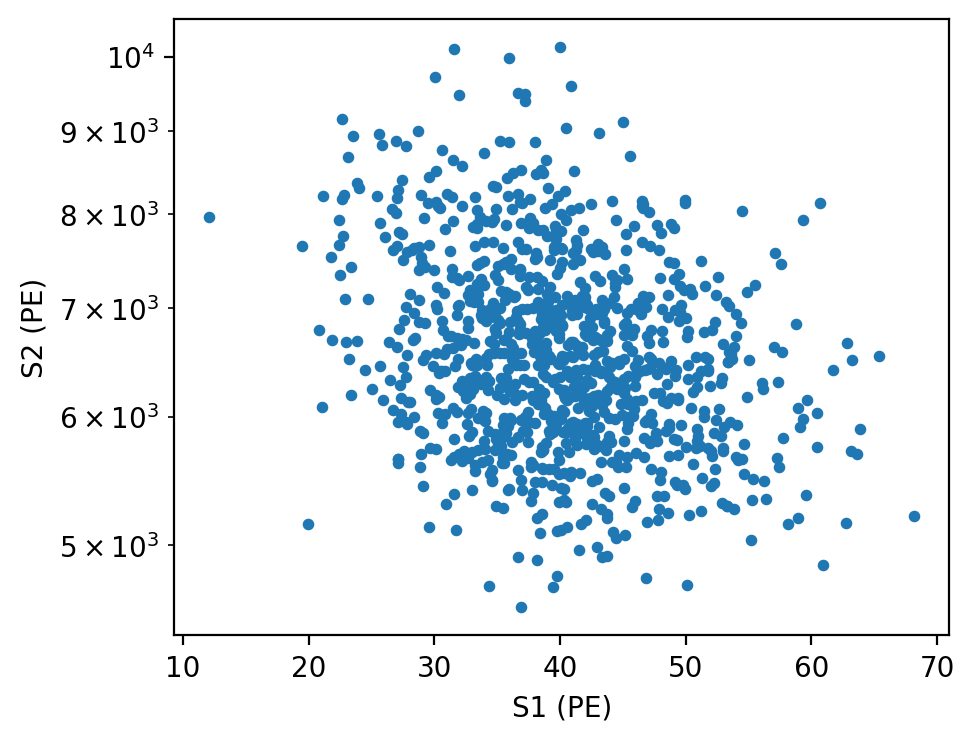

In [6]:
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(S1_nest, S2_nest, s=10)
ax.set(yscale='log', xlabel='S1 (PE)', ylabel='S2 (PE)')
plt.show()

In [7]:
Nph_bins_centers = jnp.arange(1,1399)
Nphdet_bin_centers=jnp.arange(1, 201)
Ne_bin_centers = jnp.arange(1, 400)
Ne_mat, Nphdet_mat = jnp.meshgrid(Ne_bin_centers, Nphdet_bin_centers, indexing='ij')
Ne_mat_flat = Ne_mat.flatten()
Nphdet_mat_flat = Nphdet_mat.flatten()
s2_sigma_arr = jnp.sqrt(Ne_mat_flat)*S2_sigma
s1_sigma_arr = jnp.sqrt(Nphdet_mat_flat)*PMT_sigma

In [8]:
@jax.checkpoint
@jit
def single_loglikelihood(E, S1, S2, g1, SE_gain):
    marg_prob_Ne, marg_prob_Ni, marg_prob_Nq = NEST.marginalized_prob_quantas(E, E_field=60.0)
    # summed_marg_prob = jnp.triu(jnp.einsum('ijkl,ijkl,ijkl  -> lik', marg_prob_Ne[:,:,:,:], marg_prob_Nq[jnp.newaxis, jnp.newaxis, :, :], marg_prob_Ni[jnp.newaxis, :, :, :]))
    summed_marg_prob = pmfm.sum_marg_probs(marg_prob_Ne, marg_prob_Ni, marg_prob_Nq)
    Ne_Nph_ps = pmfm.compute_Ne_Nph_ps_vmap(summed_marg_prob)
    # return Ne_Nph_ps
    # return jnp.sum(Ne_Nph_ps)
    log_Ne_Nphdet_ps = pmfm.marginalise_g1_binom(Ne_Nph_ps[0,...], g1)
    # return jnp.sum(jnp.exp(log_Ne_Nphdet_ps))
    Ne_Nphdet_ps_flat = log_Ne_Nphdet_ps.flatten()
    return jax.nn.logsumexp(-jnp.log(2*jnp.pi*s1_sigma_arr*s2_sigma_arr)-0.5*(((S1 - Nphdet_mat_flat)/s1_sigma_arr)**2 + ((S2 - Ne_mat_flat*SE_gain)/s2_sigma_arr)**2) + Ne_Nphdet_ps_flat)

In [9]:
single_loglikelihood(test_E[0], S1_nest[0], S2_nest[0], g1, SE_gain) 

Array(-12.12865023, dtype=float64)

In [11]:
def summed_loglikelihood(E, S1, S2, g1, SE_gain, N_events):
    return jax.lax.fori_loop(0, N_events, lambda i, x: single_loglikelihood(E, S1[i], S2[i], g1, SE_gain) + x, 0.0)

In [12]:
summed_loglikelihood(8.0, jnp.array(S1_nest), jnp.array(S2_nest), g1, SE_gain, 100)

Array(-1176.40510647, dtype=float64)

In [13]:
loglikelihood_value_and_grad = jax.value_and_grad(lambda x: summed_loglikelihood(8.0, jnp.array(S1_nest), jnp.array(S2_nest), x, SE_gain, 100))

In [14]:
loglikelihood_value_and_grad(0.1)

(Array(-1182.74189773, dtype=float64),
 Array(1862.06657342, dtype=float64, weak_type=True))

In [15]:
loglikelihood_value_and_grad(0.12)

(Array(-1188.98835222, dtype=float64),
 Array(-2239.04291059, dtype=float64, weak_type=True))

In [16]:
num_warmup = 30

llh_func_bjx = lambda x: summed_loglikelihood(8.0, jnp.array(S1_nest), jnp.array(S2_nest), x, SE_gain, 20)

adapt = blackjax.window_adaptation(
    blackjax.nuts, llh_func_bjx, target_acceptance_rate=0.8, progress_bar=True
)

In [17]:
%%time
key = jax.random.PRNGKey(42)
key, subkey1, subkey2 = jax.random.split(key, num=3)
(last_state, parameters), _ = adapt.run(subkey1, jax.random.uniform(subkey2, shape=(1,)), num_warmup)
kernel = blackjax.nuts(llh_func_bjx, **parameters).step

Running window adaptation



CPU times: user 4min 59s, sys: 2min 24s, total: 7min 23s
Wall time: 7min 21s


In [18]:
parameters

{'step_size': Array(0.05576688, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([0.00022228], dtype=float64)}

In [19]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, x):
        _, rng_key = x
        state, info = kernel(rng_key, state)
        return state, (state, info)
    one_step_ = progress_bar_scan(num_samples)(jax.jit((one_step)))
    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step_, initial_state, (jnp.arange(num_samples), keys))

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )


In [20]:
%%time
num_sample = 60
key, sample_key = jax.random.split(key)
states, infos = inference_loop(sample_key, kernel, last_state, num_sample)
_ = states.position.block_until_ready()



CPU times: user 34min 13s, sys: 17min 3s, total: 51min 16s
Wall time: 51min 10s


In [21]:
%%time
key, sample_key = jax.random.split(key)
states2, infos2 = inference_loop(sample_key, kernel, last_state, num_sample)
_ = states2.position.block_until_ready()



CPU times: user 25min 22s, sys: 12min 22s, total: 37min 45s
Wall time: 37min 39s


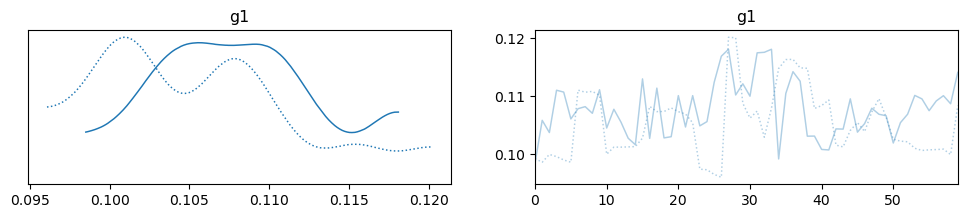

In [23]:
chain_g1 = az.from_dict(posterior={'g1': [states.position.flatten(), states2.position.flatten()]}, sample_stats={
    'acceptance_rate': [infos[0], infos2[0]],
    'is_divergent': [infos[1], infos2[1]],
    'num_integration_steps': [infos[2], infos2[2]],
})
az.plot_trace(chain_g1);

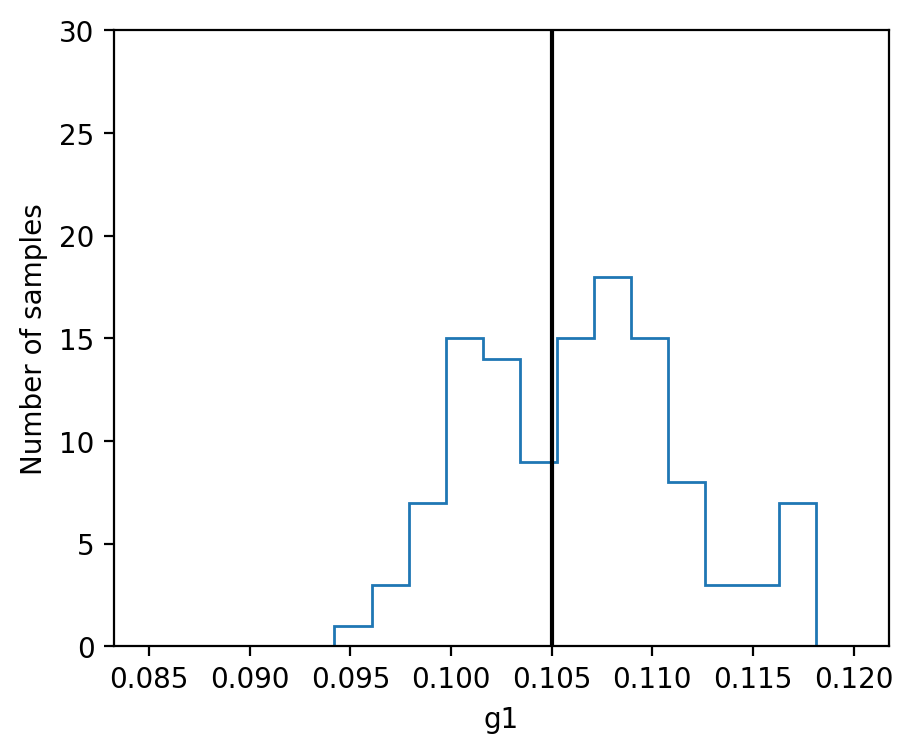

In [24]:
ylim=[0,30]
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
ax.hist(jnp.array(chain_g1.posterior['g1']).flatten(), bins=jnp.linspace(0.085, 0.12, 20), histtype='step')
ax.vlines(x=g1, ymin=ylim[0], ymax=ylim[1], color='k')
ax.set(xlabel='g1', ylabel='Number of samples', ylim=ylim)
plt.show()

In [25]:
g1_bins = jnp.linspace(0.09, 0.12, 30)
g1_likelihood = []
for i, g1_loop in enumerate(tqdm(g1_bins)):
    g1_likelihood.append(summed_loglikelihood(8.0, jnp.array(S1_nest), jnp.array(S2_nest), g1_loop, SE_gain, 20))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:54<00:00,  5.82s/it]


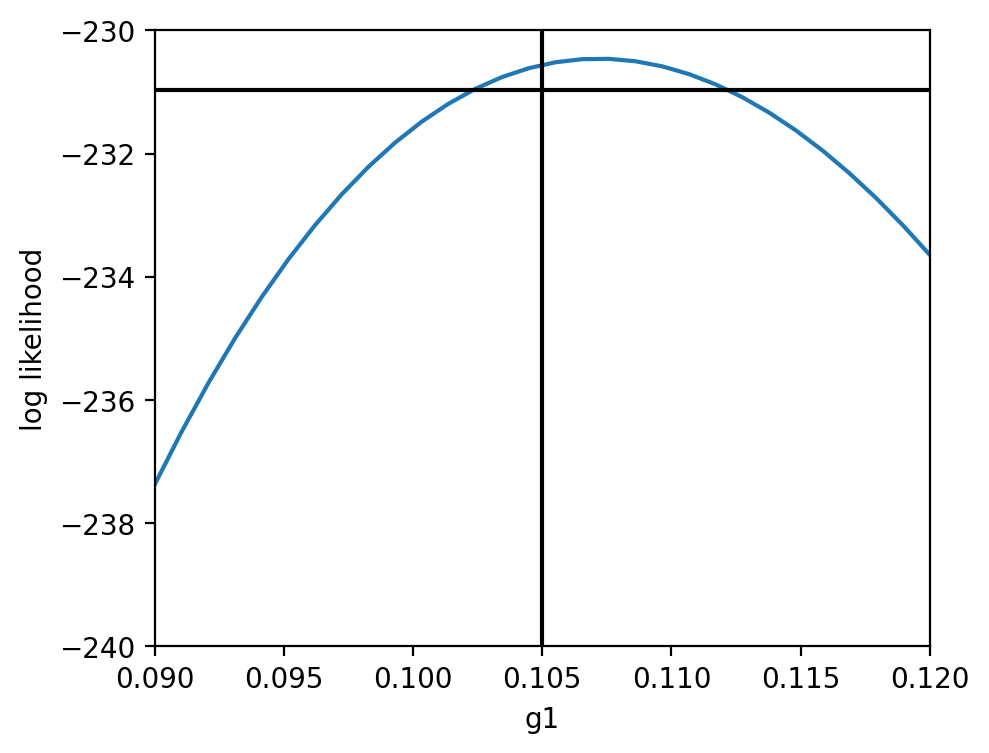

In [26]:
ylim=[-240,-230]
xlim=[g1_bins[0], g1_bins[-1]]
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
ax.plot(g1_bins, g1_likelihood)
ax.vlines(x=g1, ymin=ylim[0], ymax=ylim[1], color='k')
ax.hlines(y=np.max(g1_likelihood)-0.5, xmin=xlim[0], xmax=xlim[1], color='k')
ax.set(xlabel='g1', ylabel='log likelihood', ylim=ylim, xlim=xlim)
plt.show()

In [27]:
test_E = np.random.uniform(2,10,10)
g1 = 0.105
# g2 = 17.3
g2 = 31.8
SE_gain = 31.8
extraction_eff = g2/SE_gain
PMT_sigma = 0.8
S2_sigma = 15

Nph_nest, Ne_nest = GetQuanta(energy=test_E)
# Nq_nest = Ne_nest + Nph_nest
Nph_det_nest = spystats.binom.rvs(Nph_nest, g1)
S1_nest = spystats.norm.rvs(Nph_det_nest, jnp.sqrt(Nph_det_nest)*PMT_sigma)

Ne_det_nest = spystats.binom.rvs(Ne_nest, extraction_eff)
S2_nest = spystats.norm.rvs(Ne_det_nest*SE_gain, jnp.sqrt(Ne_det_nest)*S2_sigma)

# S2_nest = spystats.norm.rvs(Ne_nest*g2, Ne_nest/10)

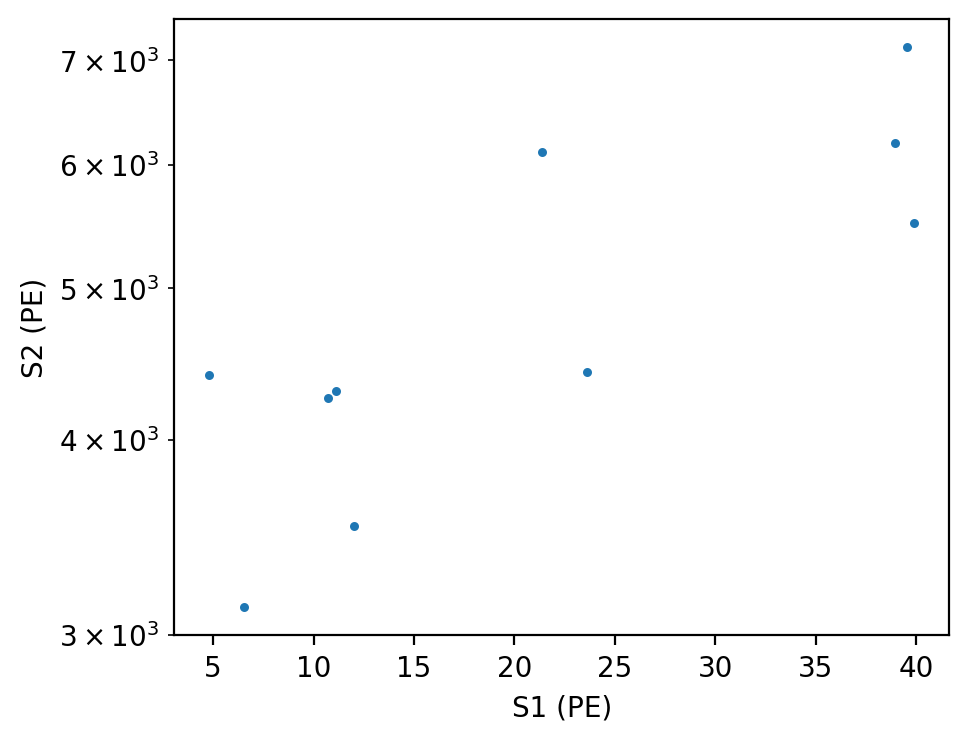

In [28]:
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
ax.scatter(S1_nest, S2_nest, s=5)
ax.set(yscale='log', xlabel='S1 (PE)', ylabel='S2 (PE)')
plt.show()

In [29]:
def summed_loglikelihood_E(E, S1, S2, g1, SE_gain, N_events):
    return jax.lax.fori_loop(0, N_events, lambda i, x: single_loglikelihood(E[i], S1[i], S2[i], g1, SE_gain) + x, 0.0)

In [35]:
num_warmup = 30

llh_func_bjx = lambda x: summed_loglikelihood_E(x, jnp.array(S1_nest), jnp.array(S2_nest), g1, SE_gain, len(test_E))

adapt = blackjax.window_adaptation(
    blackjax.nuts, llh_func_bjx, target_acceptance_rate=0.8, progress_bar=True
)

In [36]:
%%time
key = jax.random.PRNGKey(42)
key, subkey1, subkey2 = jax.random.split(key, num=3)
(last_state, parameters), _ = adapt.run(subkey1, jax.random.uniform(subkey2, shape=test_E.shape)*8+1, num_warmup)
kernel = blackjax.nuts(llh_func_bjx, **parameters).step

Running window adaptation



CPU times: user 16min 53s, sys: 8min 35s, total: 25min 28s
Wall time: 25min 31s


In [37]:
parameters

{'step_size': Array(0.88195412, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([0.58650103, 0.22349143, 0.37869618, 0.9567261 , 0.25791238,
        0.34878272, 0.28789155, 0.21204524, 0.19153301, 0.74646412],      dtype=float64)}

In [38]:
%%time
num_sample = 90
key, sample_key = jax.random.split(key)
states, infos = inference_loop(sample_key, kernel, last_state, num_sample)
_ = states.position.block_until_ready()



CPU times: user 28min 51s, sys: 14min 38s, total: 43min 29s
Wall time: 43min 28s


In [39]:
%%time
key, sample_key = jax.random.split(key)
states2, infos2 = inference_loop(sample_key, kernel, last_state, num_sample)
_ = states2.position.block_until_ready()



CPU times: user 27min 16s, sys: 13min 51s, total: 41min 7s
Wall time: 41min 6s


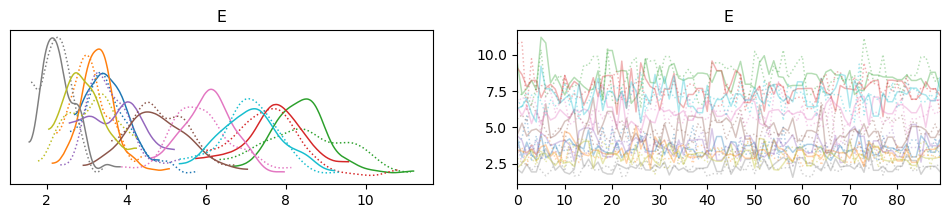

In [42]:
chain_E = az.from_dict(posterior={'E': [states.position, states2.position]}, sample_stats={
    'acceptance_rate': [infos[0], infos2[0]],
    'is_divergent': [infos[1], infos2[1]],
    'num_integration_steps': [infos[2], infos2[2]],
})
az.plot_trace(chain_E);

In [45]:
az.summary(chain_E)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
E[0],3.585,0.568,2.582,4.514,0.040,0.030,261.0,98.0,1.00
E[1],3.223,0.503,2.312,4.140,0.048,0.035,84.0,115.0,1.03
E[2],8.466,0.943,6.548,10.018,0.081,0.058,135.0,99.0,1.07
E[3],7.647,0.864,5.903,8.946,0.067,0.051,206.0,87.0,1.01
E[4],3.692,0.651,2.604,4.965,0.053,0.038,158.0,116.0,1.01
E[5],4.848,0.778,3.439,6.239,0.071,0.051,124.0,163.0,1.01
E[6],5.987,0.750,4.486,7.223,0.082,0.058,82.0,115.0,1.04
E[7],2.307,0.410,1.605,2.920,0.030,0.021,186.0,114.0,1.00
E[8],3.056,0.573,2.072,4.046,0.044,0.032,174.0,92.0,1.01
E[9],7.108,0.777,5.773,8.666,0.049,0.034,255.0,139.0,1.02


In [44]:
test_E

array([3.86969743, 2.77496894, 7.35893051, 7.06626891, 3.85373709,
       5.65373493, 8.08482161, 2.2348902 , 2.5001555 , 5.93183173])

In [63]:
inferred_energies = jnp.median(jnp.vstack(chain_E.posterior['E'].values), axis=0)

In [65]:
inferred_E_low = jnp.quantile(jnp.vstack(chain_E.posterior['E'].values), stats.norm.cdf(-1),axis=0)

In [66]:
inferred_E_hi = jnp.quantile(jnp.vstack(chain_E.posterior['E'].values), stats.norm.cdf(1),axis=0)

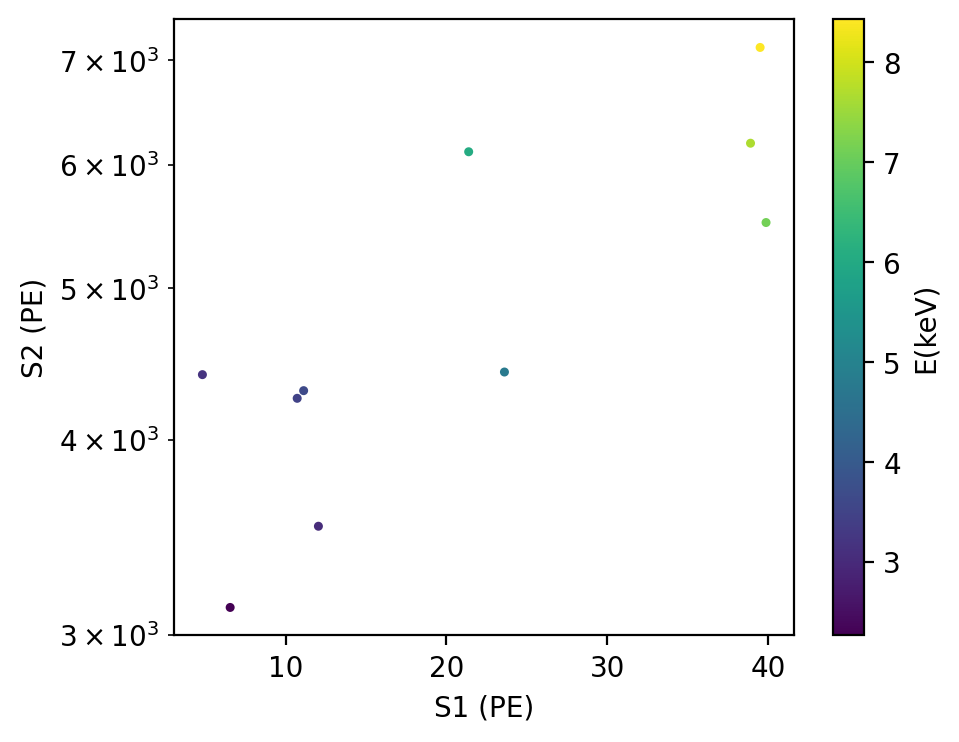

In [67]:
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
s = ax.scatter(S1_nest, S2_nest, s=5, c=inferred_energies)
plt.colorbar(s, label='E(keV)')
ax.set(yscale='log', xlabel='S1 (PE)', ylabel='S2 (PE)')
plt.show()

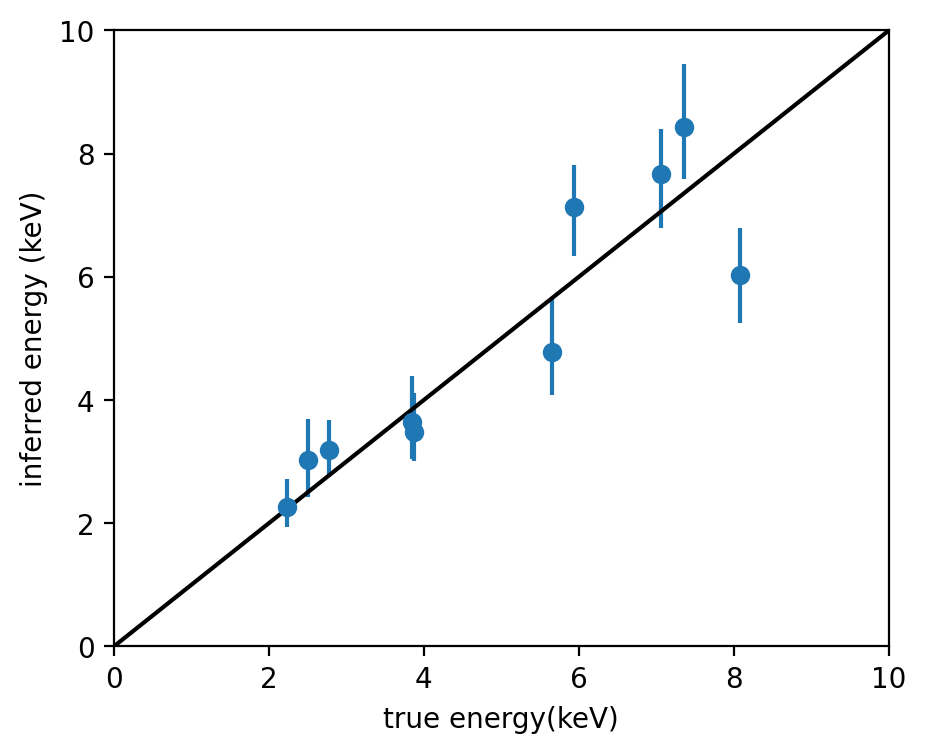

In [74]:
fig = plt.figure(figsize=(5,4), dpi=200)
ax = fig.add_subplot(111)
ax.errorbar(test_E, inferred_energies, yerr=[(inferred_energies-inferred_E_low), (inferred_E_hi-inferred_energies)], linestyle='', marker='o')
ax.plot([0, 10], [0,10], 'k')
ax.set(xlabel='true energy(keV)', ylabel='inferred energy (keV)', xlim=[0,10], ylim=[0,10])
plt.show()

In [111]:
inferred_energies-inferred_E_low

Array([[0.96053329, 0.43482373, 0.62447562, 0.53127161, 0.62344687]],      dtype=float64)

In [112]:
inferred_energies

Array([[7.00084524, 4.36053049, 5.64542799, 5.90643801, 5.84016801]],      dtype=float64)

In [114]:
test_E

array([7.76557136, 4.28625458, 5.65955539, 8.37603126, 6.07450087])